In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import wandb
import pickle
import os


#TODO: load best_models, get log probs, and then do logp - logq
#TODO: remove outliers and check SIC curve
#TODO: smaller nflow for CR region

In [48]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'm_anode_compile.ipynb'

In [3]:
cd ..

/home/rd804/m-anode


In [49]:
pwd

'/home/rd804/m-anode'

In [50]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [51]:
import wandb

In [7]:

group_name = 'nflows_gaussian_mixture_1'

with open('data/data.pkl', 'rb') as f:
     data = pickle.load(f)

with open('data/background.pkl', 'rb') as f:
     background = pickle.load(f)

print(background.shape)

with open('results/true_w.pkl', 'rb') as f:
    true_w = pickle.load(f)



back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3


(100000,)


In [52]:

# For each sigma, generate all SIC curves,
# and get the average max SIC curve for each sigma
# get average AUC for each sigma
# get average SIC_01 for each sigma
# get average SIC_001 for each sigma

wandb.init(project='m-anode', group=group_name, job_type='M_ANODE_summary',
           config = {'device':device, 'back_mean':back_mean, 'sig_mean':sig_mean,
                     'sig_simga':sig_simga, 'back_sigma':back_sigma, 'test_set':'10',
                     'test_sigma':100})

wandb.run.name = 'M_ANODE_summary_10'



x_test = data['10']['val']['data']
label_test = data['10']['val']['label']
test_tensor = torch.from_numpy(x_test.astype('float32').reshape((-1,1))).to(device)
model = define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0,device=device)

CR_array = []
for try_ in range(10):
    CR_file = f'results/nflows_gaussian_mixture_1/CR/try_{try_}'
    best_model_file = f'{CR_file}/model_CR_best.pt'

    model.load_state_dict(torch.load(best_model_file))
    model.eval()
    model.to(device)

    with torch.no_grad():
        CR = model.log_prob(test_tensor).cpu().detach().numpy()

    CR_p = np.exp(CR)
    CR_array.append(CR_p)

CR_array = np.array(CR_array)
mean_CR = np.mean(CR_array,axis=0)
# replace 0 with a small number
mean_CR[mean_CR==0] = 1e-10

mean_log_CR = np.log(mean_CR)

    


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find m_anode_compile.ipynb.
wandb: Currently logged in as: rd804. Use `wandb login --relogin` to force relogin


array([ 0.1,  0.2,  0.5,  0.8,  0.9,  1. ,  1.5,  2. ,  5. , 10. ])

In [32]:


#summary = {}
sig_train_list = [0.1, 0.2, 0.5, 0.8, 0.9, 1, 1.5, 2, 5 , 10]

print(sig_train_list)


_true_max_SIC = []
_true_AUC = []
_true_SIC_01 = []
_true_SIC_001 = []

max_SIC_avg_m = []
AUC_avg_m = []
SIC_01_avg_m = []
SIC_001_avg_m = []

max_SIC_std_m = []
AUC_std_m = []
SIC_01_std_m = []
SIC_001_std_m = []


summary_m = {}




for sig_train in sig_train_list:
    _max_SIC = []
    _AUC = []
    _SIC_01 = []
    _SIC_001 = []
    print(f'sig_train: {sig_train}')



    w1 = true_w[str(sig_train)][0]
    w2 = true_w[str(sig_train)][1]
    true_likelihood = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)
    sic_true , tpr_true , auc_true = SIC(label_test, true_likelihood)
    sic_true_01 = SIC_fpr(label_test, true_likelihood, 0.1)
    sic_true_001 = SIC_fpr(label_test, true_likelihood, 0.01)

    _true_max_SIC.append(np.max(sic_true))
    _true_AUC.append(auc_true)
    _true_SIC_01.append(sic_true_01)
    _true_SIC_001.append(sic_true_001)


    for try_ in range(10):

      #  print(f'try: {try_}')
        model = define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0,device=device)
        SR_file = f'results/nflows_gaussian_mixture_1/m_anode_true_likelihood_b_freeze_{sig_train}/try_{try_}'

        if not os.path.exists(f'{SR_file}/valloss.npy'):
            continue
        
        valloss = np.load(f'{SR_file}/valloss.npy')
        best_epoch = np.argmin(valloss)
       # print


        best_model_file = f'{SR_file}/model_S_{best_epoch}.pt'
        model.load_state_dict(torch.load(best_model_file))
        model.eval()
        model.to(device)

        with torch.no_grad():
            SR = model.log_prob(test_tensor).cpu().detach().numpy()


        likelihood_score = (SR - mean_log_CR)
        sic , tpr , auc = SIC(label_test, likelihood_score)

        _max_SIC.append(np.max(sic))
        _AUC.append(auc)

        sic_01 = SIC_fpr(label_test, likelihood_score, 0.1)
        sic_001 = SIC_fpr(label_test, likelihood_score, 0.01)

        _SIC_01.append(sic_01)
        _SIC_001.append(sic_001)

     #   figure = plt.figure()

    #    plt.plot(tpr,sic,label='SIC: AUC {:.3f}'.format(auc))
     #   plt.plot(tpr_true,sic_true,label='true: AUC {:.3f}'.format(auc_true))
      #  plt.xlabel('TPR')
       # plt.ylabel('SIC')
       # plt.title(f'SR: {sig_train}, try: {try_}')
       # plt.legend()
       # plt.savefig(f'{SR_file}/SIC.png')
       # plt.close()

    max_SIC_avg_m.append(np.mean(_max_SIC))
    max_SIC_std_m.append(np.std(_max_SIC))

    AUC_avg_m.append(np.mean(_AUC))
    AUC_std_m.append(np.std(_AUC))

    SIC_01_avg_m.append(np.mean(_SIC_01))
    SIC_01_std_m.append(np.std(_SIC_01))

    SIC_001_avg_m.append(np.mean(_SIC_001))
    SIC_001_std_m.append(np.std(_SIC_001))



[0.1, 0.2, 0.5, 0.8, 0.9, 1, 1.5, 2, 5, 10]
sig_train: 0.1


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divi

sig_train: 0.2


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divi

sig_train: 0.5


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in div

sig_train: 0.8


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divid

sig_train: 0.9


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divi

sig_train: 1


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divid

sig_train: 1.5


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in div

sig_train: 2


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divi

sig_train: 5


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in di

sig_train: 10


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in di

In [41]:


#summary = {}
#sig_train_list = [5, 0.1, 0.2, 0.5, 0.8, 0.9, 1, 2, 1.5, 10]
_true_max_SIC = []
_true_AUC = []
_true_SIC_01 = []
_true_SIC_001 = []

max_SIC_avg = []
AUC_avg = []
SIC_01_avg = []
SIC_001_avg = []

max_SIC_std = []
AUC_std = []
SIC_01_std = []
SIC_001_std = []


summary = {}




for sig_train in sig_train_list:
    _max_SIC = []
    _AUC = []
    _SIC_01 = []
    _SIC_001 = []
  #  print(f'sig_train: {sig_train}')



    w1 = true_w[str(sig_train)][0]
    w2 = true_w[str(sig_train)][1]
    true_likelihood = p_data(x_test,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_test,back_mean,back_sigma**2)
    sic_true , tpr_true , auc_true = SIC(label_test, true_likelihood)
    sic_true_01 = SIC_fpr(label_test, true_likelihood, 0.1)
    sic_true_001 = SIC_fpr(label_test, true_likelihood, 0.01)

    _true_max_SIC.append(np.max(sic_true))
    _true_AUC.append(auc_true)
    _true_SIC_01.append(sic_true_01)
    _true_SIC_001.append(sic_true_001)


    for try_ in range(10):

        model = define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0,device=device)

        SR_file = f'results/nflows_gaussian_mixture_1/SR_{sig_train}/try_{try_}'
        best_model_file = f'{SR_file}/model_SR_best.pt'

        model.load_state_dict(torch.load(best_model_file))
        model.eval()
        model.to(device)

        with torch.no_grad():
            SR = model.log_prob(test_tensor).cpu().detach().numpy()


        likelihood_score = (SR - mean_log_CR)
        sic , tpr , auc = SIC(label_test, likelihood_score)

        _max_SIC.append(np.max(sic))
        _AUC.append(auc)

        sic_01 = SIC_fpr(label_test, likelihood_score, 0.1)
        sic_001 = SIC_fpr(label_test, likelihood_score, 0.01)

        _SIC_01.append(sic_01)
        _SIC_001.append(sic_001)

     #   figure = plt.figure()

    #    plt.plot(tpr,sic,label='SIC: AUC {:.3f}'.format(auc))
     #   plt.plot(tpr_true,sic_true,label='true: AUC {:.3f}'.format(auc_true))
      #  plt.xlabel('TPR')
       # plt.ylabel('SIC')
       # plt.title(f'SR: {sig_train}, try: {try_}')
       # plt.legend()
       # plt.savefig(f'{SR_file}/SIC.png')
       # plt.close()

    max_SIC_avg.append(np.mean(_max_SIC))
    max_SIC_std.append(np.std(_max_SIC))

    AUC_avg.append(np.mean(_AUC))
    AUC_std.append(np.std(_AUC))

    SIC_01_avg.append(np.mean(_SIC_01))
    SIC_01_std.append(np.std(_SIC_01))

    SIC_001_avg.append(np.mean(_SIC_001))
    SIC_001_std.append(np.std(_SIC_001))



sig_train: 0.1


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divi

sig_train: 0.2


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

sig_train: 0.5


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

sig_train: 0.8


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

sig_train: 0.9


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

sig_train: 1


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

sig_train: 1.5


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divid

sig_train: 2


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

sig_train: 5


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

sig_train: 10


/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:13: RuntimeWarning: invalid value encountered in divide

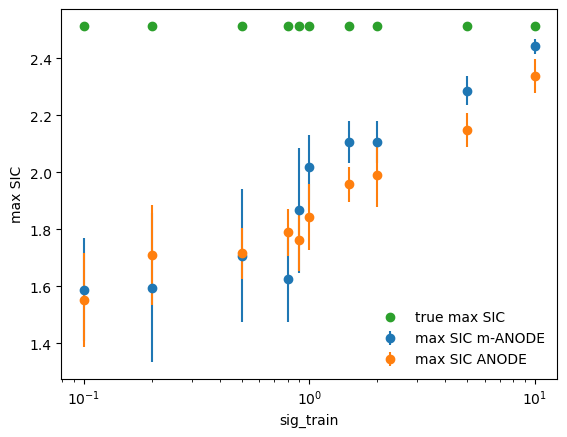

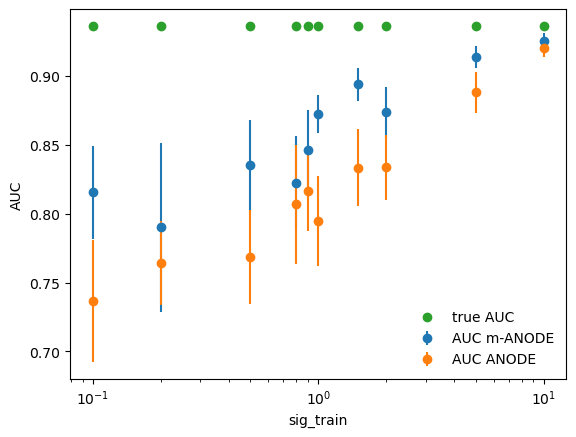

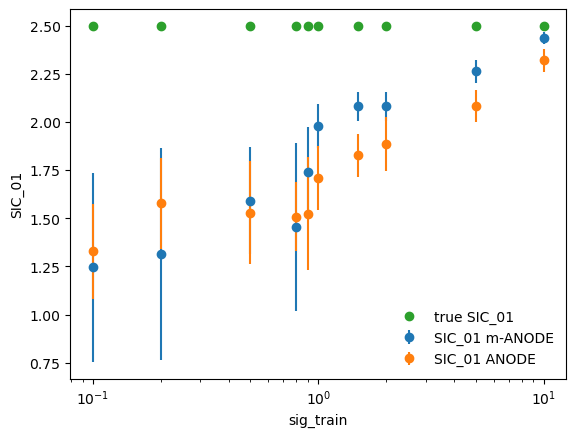

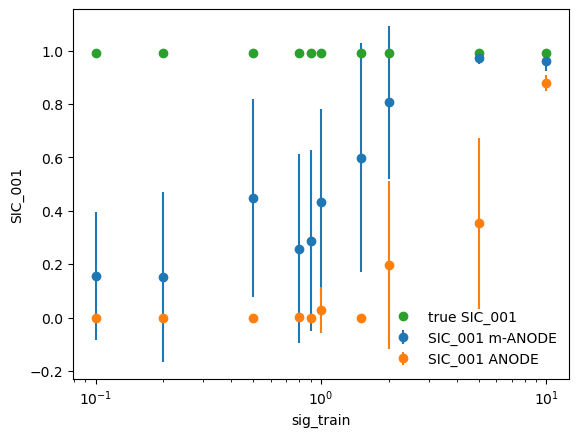

In [53]:

ANODE_file = f'results/nflows_gaussian_mixture_1'

figure = plt.figure()

#sorted = np.argsort(sig_train_list)

# fill between for std


plt.errorbar(sig_train_list,max_SIC_avg_m,yerr=max_SIC_std_m,label='max SIC m-ANODE',fmt='o')
plt.errorbar(sig_train_list,max_SIC_avg,yerr=max_SIC_std,label='max SIC ANODE',fmt='o')
plt.plot(sig_train_list,_true_max_SIC,'o',label='true max SIC', color='C2')
plt.xlabel('sig_train')
plt.ylabel('max SIC')
plt.xscale('log')
plt.legend(loc = 'lower right', frameon=False)
plt.savefig('anode_max_SIC.png')
plt.savefig(f'{ANODE_file}/m_anode_max_SIC.png')
wandb.log({'max_SIC': wandb.Image(figure)})
#plt.close()
plt.show()

figure = plt.figure()

plt.errorbar(sig_train_list,AUC_avg_m,yerr=AUC_std_m,label='AUC m-ANODE',fmt='o')
plt.errorbar(sig_train_list,AUC_avg,yerr=AUC_std,label='AUC ANODE',fmt='o')
plt.plot(sig_train_list,_true_AUC,'o',label='true AUC', color='C2')
plt.xlabel('sig_train')
plt.ylabel('AUC')
plt.legend()
plt.xscale('log')
plt.legend(loc = 'lower right', frameon=False)
#plt.savefig('anode_AUC.png')
plt.savefig(f'{ANODE_file}/m_anode_AUC.png')
wandb.log({'AUC': wandb.Image(figure)})
#plt.close()
plt.show()

figure = plt.figure()
plt.errorbar(sig_train_list,SIC_01_avg_m,yerr=SIC_01_std_m,label='SIC_01 m-ANODE',fmt='o')
plt.errorbar(sig_train_list,SIC_01_avg,yerr=SIC_01_std,label='SIC_01 ANODE',fmt='o')
plt.plot(sig_train_list,_true_SIC_01,'o',label='true SIC_01')
plt.xlabel('sig_train')
plt.ylabel('SIC_01')
plt.legend()
plt.xscale('log')
plt.legend(loc = 'lower right', frameon=False)
#plt.savefig('anode_SIC_01.png')
plt.savefig(f'{ANODE_file}/m_anode_SIC_01.png')
wandb.log({'SIC_01': wandb.Image(figure)})
#plt.close()
plt.show()

figure = plt.figure()
plt.errorbar(sig_train_list,SIC_001_avg_m,yerr=SIC_001_std_m,label='SIC_001 m-ANODE',fmt='o')
plt.errorbar(sig_train_list,SIC_001_avg,yerr=SIC_001_std,label='SIC_001 ANODE',fmt='o')
plt.plot(sig_train_list,_true_SIC_001,'o',label='true SIC_001')
plt.xlabel('sig_train')
plt.ylabel('SIC_001')
plt.legend()
plt.xscale('log')
plt.legend(loc = 'lower right', frameon=False)
plt.savefig('anode_SIC_001.png')
plt.savefig(f'{ANODE_file}/m_anode_SIC_001.png')
wandb.log({'SIC_001': wandb.Image(figure)})
#plt.close()
plt.show()

wandb.finish()


In [ ]:

summary_m['sig_train'] = sig_train_list
summary_m['max_SIC_avg'] = max_SIC_avg_m
summary_m['max_SIC_std'] = max_SIC_std_m
summary_m['AUC_avg'] = AUC_avg_m
summary_m['AUC_std'] = AUC_std_m
summary_m['SIC_01_avg'] = SIC_01_avg_m
summary_m['SIC_01_std'] = SIC_01_std_m
summary_m['SIC_001_avg'] = SIC_001_avg_m
summary_m['SIC_001_std'] = SIC_001_std_m


#with open(f'{ANODE_file}/summary.pkl', 'wb') as f:
 #   pickle.dump(summary_m, f, pickle.HIGHEST_PROTOCOL)





[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

[]